## Library

Load all the needed library. <br>
<u>Needed library</u> : numpy, matplotlib, pandas, tensorflow, skopt, keras, sklearn

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import json
import tensorflow as tf
import statistics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

from sklearn.metrics import r2_score

## Function

In this study, parameter below are studied:

| Parameter | Value | Notes |
|:---------|:------------:|:--------------|
| Learning rate | 10$^{-6}$-10$^{-2}$ | Learning rate of the optimizer function |
| Number of layers | 1 - 3 | Number of hidden layer | 
| Number of neurons | 2 - 20 | Number of nodes in each hidden layer | 
| Activation function | Relu | Activation function on each nodes | 
| Optimizer | Adam | Function to optimize the NN | 
| Batch size | 64 | Data points that pass through NN every step | 
| Dropout | - | Proobability where nodes are randomly disconected during training | 
| Epoch | 100 | Amount of times to go through our training data |


In [2]:
# Model definition
def ANN_model(features, target, learn_rate, layers, nodes):
    """
    Input Data:
    features   : Input data for the ANN (numpy array)
    target     : Output of the ANN (numpy array)
    learn_rate : Learning-rate for the optimizer.
    layers     : Number of dense layers.
    nodes      : Number of nodes in each dense layer.
    """
        
    # Define model
    model = Sequential()
    if layers == 1:
        # Input layer
        model.add(Dense(nodes, activation='relu', 
                       input_dim=features.shape[1]))      
    else:
        model.add(Dense(nodes, activation='relu', 
                       input_dim=features.shape[1]))
        for i in range(layers-1):
            model.add(Dense(nodes, activation='relu'))

    # Add output layer, 1 nodes
    model.add(Dense(1, activation='linear'))

    adam = Adam(lr=learn_rate)
    model.compile(optimizer=adam, loss='mse',
                  metrics=['mean_absolute_percentage_error',
                           'RootMeanSquaredError'])
    
    return model

In [3]:
# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=1, high=3, name='layers')
dim_nodes = Integer(low=2, high=5, name='nodes')
                             
dimensions = [dim_learn_rate, dim_layers, dim_nodes]

# Function
@use_named_args(dimensions=dimensions)
def ANN_study(learn_rate, layers, nodes):
    """
    Hyper-parameters:
    features    : Input of the ANN (np.array)
    target      : Output of the ANN (np.array)
    val_features: Input of the ANN for validation (np.array)
    val_target  : Output of the ANN for validation (np.array)
    learn_rate  : Learning-rate for the optimizer.
    layers      : Number of dense layers.
    nodes       : Number of nodes in each dense layer.
    activation  : Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('Learning rate: {0:.1e}'.format(learn_rate))
    print('Dense layers:', layers)
    print('Nodes:', nodes)
    
    model = ANN_model(features=features, 
                         target=target,
                         learn_rate=learn_rate,
                         layers=layers,
                         nodes=nodes)

    # Use Keras to train the model.
    patience = 20
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, 
                       patience=patience, restore_best_weights=True)
    history = model.fit(features, target, verbose=0, epochs=num_epochs, batch_size = 64,
                    validation_data=(val_features, val_target), callbacks=[es])

    # Get the regression validation loss
    # after the last training-epoch.
    if es.stopped_epoch == 0:
        loss = history.history['loss'][-1]
    else:
        loss = history.history['loss'][es.stopped_epoch-patience]

    # Print the validation loss.
    print()
    print('loss:', loss)
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_loss

    # If the validation loss of the saved model is improved ...
    if loss < best_loss:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the regression accuracy.
        best_loss = loss
        
        #save the history of the best model
        ANN_performance = history.history
        temp = json.dumps(ANN_performance)
        f = open(path_best_model_performance,"w")
        f.write(temp)
        f.close()

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization
    return loss

## Result Plot
Here, functions and plots that used to assess the robustness for each proxy segments is written.

In [4]:
# function for Error and Accuracy of the ANN
def plot_error_acc(history):
    # history = Fitted ANN model to our dataset

    # Loss Function Plot
    plt.figure(1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MSE]')
    plt.legend()
    plt.grid(True)

    # MAPE Plot
    plt.figure(2)
    plt.plot(history['mean_absolute_percentage_error'], label='Training')
    plt.plot(history['val_mean_absolute_percentage_error'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE (%)')
    plt.ylim([0, 50])
    plt.legend()
    plt.grid(True)

    # RMSE Plot
    plt.figure(3)
    plt.plot(history['root_mean_squared_error'], label='Training')
    plt.plot(history['val_root_mean_squared_error'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

# Error distribution and proxy performance function for test data
def plot_train_performance(model, train_input, train_output, val_input, val_output, lims):
    # model = the ANN model (fitted)
    # train_input = input for the ANN from training database
    # train_output = output of the training database
    # val_input = input for the ANN from validation database
    # val_output = output of the validation database
    # lims = 2 points [min,max] for the plot boundary

    # Calculate test data with the model
    train_predictions = model.predict(train_input).flatten()
    val_predictions = model.predict(val_input).flatten()

    # Checking performance of test data
    plt.figure(4)
    plt.axes(aspect='equal')
    plt.scatter(train_output, train_predictions, label='Training')
    plt.scatter(val_output, val_predictions, label='Validation', marker='x')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
    # Getting error distribution
    plt.figure(5)
    error_train = train_predictions - train_output
    error_val = val_predictions - val_output
    plt.hist(error_train, bins=25)
    plt.hist(error_val, bins=25)
    plt.xlabel('Prediction Error [Error]')
    _ = plt.ylabel('Count')
    
    # Calculate R^2
    r2_train = r2_score(train_output, train_predictions)
    r2_val = r2_score(val_output, val_predictions)
    print("R-square Training: {:.6f}".format(r2_train))
    print("R-square Validation: {:.6f}".format(r2_val))
    
    # Calculate Training Absolute Error (AE)
    ape_train = abs(train_output-train_predictions)
    max_ape_train = max(ape_train)
    mean_ape_train = statistics.mean(ape_train)
    min_ape_train = min(ape_train)
    print("""Training Average Absolute Error:
    - Maximum=%.6f
    - Mean=%.6f
    - Minimum=%.6f""" % (max_ape_train, mean_ape_train, min_ape_train))
    
    # Calculate Validation Absolute Error (AE)
    ape_val = abs(val_output-val_predictions)
    max_ape_val = max(ape_val)
    mean_ape_val = statistics.mean(ape_val)
    min_ape_val = min(ape_val)
    print("""Validation Average Absolute Error:
    - Maximum=%.6f
    - Mean=%.6f
    - Minimum=%.6f""" % (max_ape_val, mean_ape_val, min_ape_val))

# Error distribution and proxy performance function for test data
def plot_test_performance(model, test_input, test_output,lims):
    # model = the ANN model (fitted)
    # test_input = input for the ANN from test database
    # test_output = output of the test database
    # lims = 2 points [min,max] for the plot boundary

    # Calculate test data with the model
    test_predictions = model.predict(test_input).flatten()

    # Checking performance of test data
    plt.figure(6)
    plt.axes(aspect='equal')
    plt.scatter(test_output, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
    # Getting error distribution
    plt.figure(7)
    error = test_predictions - test_output
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Error]')
    _ = plt.ylabel('Count')
    
    # Calculate R^2
    r2_test = r2_score(test_output, test_predictions)
    print("R-square Test: {:.6f}".format(r2_test))
    
    # Calculate Absolute Error (APE)
    ape_test = abs(test_output-test_predictions)
    max_ape_test = max(ape_test)
    mean_ape_test = statistics.mean(ape_test)
    min_ape_test = min(ape_test)
    print("""Average Absolute Error:
    - Maximum=%.6f
    - Mean=%.6f
    - Minimum=%.6f""" % (max_ape_test, mean_ape_test, min_ape_test))

## Input data
Upload the data that obtained from Eclipse. Data separated into 75:25 for training and validation. It is randomized with seed=10 for reproducibility. We forced the edge of LHS to be used as training set

In [5]:
# Importing database
field_proxy_database = pd.read_excel('Gullfaks_Data.xlsx')

In [6]:
# Making new copy of database
main_database = field_proxy_database.copy()

# Sampling based on cases number, seed (10) for reproducible result
train_percent = 0.75
val_percent = 0.25
# test = 0.15

solutionspace=3
train = train_percent * max(main_database['Case'])-2**solutionspace

# Not to include solution space edge to validation
num_cases = np.arange(1, max(main_database['Case'])+1-2**solutionspace)
np.random.seed(10)
np.random.shuffle(num_cases)
train_case, val_case = np.split(num_cases, [int(train)])
train_case = np.append(train_case,[90, 91, 92, 93, 94, 95, 96, 97])

# Labeling database based on training, validation, test cases
main_database['Identifier'] = main_database['Case'].apply(lambda x: 'Train' if x in train_case else 'Validation')

In [7]:
def ANNdataset (main_database, input_set, output_set):    
    train_dataset = main_database[main_database['Identifier'] == 'Train']
    val_dataset = main_database[main_database['Identifier'] == 'Validation']
    
    unneeded_columns = main_database.columns.tolist()
    
    for x in input_set:
        unneeded_columns.remove(x)
        
    unneeded_columns.remove(output_set)

    train_dataset = train_dataset.drop(unneeded_columns, axis=1)
    val_dataset = val_dataset.drop(unneeded_columns, axis=1)
    
    train_label = train_dataset.pop(output_set).to_numpy()
    train_features = train_dataset.to_numpy()

    val_label = val_dataset.pop(output_set).to_numpy()
    val_features = val_dataset.to_numpy()
    return train_features, train_label, val_features, val_label

### Splitting the database for preferred proxy segmentations

In [8]:
d={}
# FOPR database
for i in range(1, 5):
    time_database = main_database[main_database['RealTimestep'] > (i-1)*360*2.5]
    
    # since it is 122 weeks, the last 2 weeks added to the last time interval
    if i == 4:
        time_database = time_database
    else:
        time_database = time_database[time_database['RealTimestep'] <= i*360*2.5]
            
    gas_database = time_database[time_database['FGIR [sm3/d]'] >= 1]
    water_database = time_database[time_database['FGIR [sm3/d]'] < 1]
    
    input_set = ['Halfcycle day', 'qgtot', 'qwtot', 'Timestep', 'FOPR (t-1)']
    output_set = 'FOPR [sm3/d]'
    
    FOPR_FgTf, FOPR_FgTl, FOPR_FgVf, FOPR_FgVl = ANNdataset(gas_database, input_set, output_set)
    FOPR_FwTf, FOPR_FwTl, FOPR_FwVf, FOPR_FwVl = ANNdataset(water_database, input_set, output_set)
        
    d["FOPR_FgTf{0}".format(i)] = FOPR_FgTf
    d["FOPR_FgTl{0}".format(i)] = FOPR_FgTl
    d["FOPR_FgVf{0}".format(i)] = FOPR_FgVf
    d["FOPR_FgVl{0}".format(i)] = FOPR_FgVl

    d["FOPR_FwTf{0}".format(i)] = FOPR_FwTf
    d["FOPR_FwTl{0}".format(i)] = FOPR_FwTl
    d["FOPR_FwVf{0}".format(i)] = FOPR_FwVf
    d["FOPR_FwVl{0}".format(i)] = FOPR_FwVl  
    
# CO2 database
for i in range(0, 5):
    if i==0:
        time_database = main_database[main_database['RealTimestep'] > 0]
        time_database = time_database[time_database['RealTimestep'] <= 360]
        
        input_set = ['Halfcycle day', 'qgtot', 'qwtot', 'Timestep', 'FCO2PR (t-1)']
        output_set = 'FCO2PR [kg-mole/d]'
        CO2_FTf, CO2_FTl, CO2_FVf, CO2_FVl = ANNdataset(time_database, input_set, output_set)

        d["CO2_FTf{0}".format(i)] = CO2_FTf
        d["CO2_FTl{0}".format(i)] = CO2_FTl
        d["CO2_FVf{0}".format(i)] = CO2_FVf
        d["CO2_FVl{0}".format(i)] = CO2_FVl

    else:
        if i == 1:
            time_database = main_database[main_database['RealTimestep'] > 360]
        else:
            time_database = main_database[main_database['RealTimestep'] > (i-1)*360*2.5]

        # since it is 122 weeks, the last 2 weeks added to the last time interval
        if i == 4:
            time_database = time_database
        else:
            time_database = time_database[time_database['RealTimestep'] <= i*360*2.5]

        gas_database = time_database[time_database['FGIR [sm3/d]'] >= 1]
        water_database = time_database[time_database['FGIR [sm3/d]'] < 1]

        input_set = ['Halfcycle day', 'qgtot', 'qwtot', 'Timestep', 'FCO2PR (t-1)']
        output_set = 'FCO2PR [kg-mole/d]'
        CO2_FgTf, CO2_FgTl, CO2_FgVf, CO2_FgVl = ANNdataset(gas_database, input_set, output_set)
        CO2_FwTf, CO2_FwTl, CO2_FwVf, CO2_FwVl = ANNdataset(water_database, input_set, output_set)

        d["CO2_FgTf{0}".format(i)] = CO2_FgTf
        d["CO2_FgTl{0}".format(i)] = CO2_FgTl
        d["CO2_FgVf{0}".format(i)] = CO2_FgVf
        d["CO2_FgVl{0}".format(i)] = CO2_FgVl

        d["CO2_FwTf{0}".format(i)] = CO2_FwTf
        d["CO2_FwTl{0}".format(i)] = CO2_FwTl
        d["CO2_FwVf{0}".format(i)] = CO2_FwVf
        d["CO2_FwVl{0}".format(i)] = CO2_FwVl

## Developing ANN for each Segments

In [9]:
ANNinfo={}
# the first 1 year interval of FCO2PR
# Initialization before hyperparameter study
path_best_model = "CO2_proxy_0.keras"
path_best_model_performance = "CO2_proxy_performance_0.json"
best_loss = 1e20
num_epochs = 100
features, target, val_features, val_target = d["CO2_FTf0"], d["CO2_FTl0"], d["CO2_FVf0"], d["CO2_FVl0"]

# Hyper-Parameter Tuning
# Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learn_rate')
dim_layers = Integer(low=2, high=3, name='layers')
dim_nodes = Integer(low=2, high=20, name='nodes')

dimensions = [dim_learn_rate, dim_layers, dim_nodes]

default_parameters = [1e-5, 2, 5]

search_result = gp_minimize(func=ANN_study, dimensions=dimensions,
                        acq_func='EI',# Expected Improvement.
                        n_calls=80, x0=default_parameters)

ANNinfo["Learning rate FCO2PR 0"]=search_result.x[0]
ANNinfo["Hidden layers FCO2PR 0"]=search_result.x[1]
ANNinfo["Number of nodes FCO2PR 0"]=search_result.x[2]

# Refit with higher epoch
learn_rate = search_result.x[0]
layers = search_result.x[1]
nodes = search_result.x[2]

ANN_model(features, target, learn_rate, layers, nodes)

model = ANN_model(features, target, learn_rate, layers, nodes)
history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                    validation_data=(val_features, val_target))

model.save(path_best_model)

#save the history of the best model
ANN_performance = history.history
temp = json.dumps(ANN_performance)
f = open(path_best_model_performance,"w")
f.write(temp)
f.close()

# Delete the Keras model with these hyper-parameters from memory.
del model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

# for other intervals
for i in range(1, 5):
    # FOPR Gas
    # Initialization before hyperparameter study
    path_best_model = "FOPR_gas_proxy_{0}.keras".format(i)
    path_best_model_performance = "FOPR_gas_proxy_performance_{0}.json".format(i)
    best_loss = 1e20
    features, target, val_features, val_target = d["FOPR_FgTf{0}".format(i)], d["FOPR_FgTl{0}".format(i)], d["FOPR_FgVf{0}".format(i)], d["FOPR_FgVl{0}".format(i)]
    
    # Hyper-Parameter Tuning
    # Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
    dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                             name='learn_rate')
    dim_layers = Integer(low=2, high=3, name='layers')
    dim_nodes = Integer(low=2, high=20, name='nodes')

    dimensions = [dim_learn_rate, dim_layers, dim_nodes]

    default_parameters = [1e-5, 2, 5]
    
    search_result = gp_minimize(func=ANN_study, dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80,x0=default_parameters)
    
    ANNinfo["Learning rate FOPRg {0}".format(i)]=search_result.x[0]
    ANNinfo["Hidden layers FOPRg {0}".format(i)]=search_result.x[1]
    ANNinfo["Number of nodes FOPRg {0}".format(i)]=search_result.x[2]
    
    # Refit with higher epoch
    learn_rate = search_result.x[0]
    layers = search_result.x[1]
    nodes = search_result.x[2]

    ANN_model(features, target, learn_rate, layers, nodes)

    model = ANN_model(features, target, learn_rate, layers, nodes)
    history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                        validation_data=(val_features, val_target))

    model.save(path_best_model)

    #save the history of the best model
    ANN_performance = history.history
    temp = json.dumps(ANN_performance)
    f = open(path_best_model_performance,"w")
    f.write(temp)
    f.close()

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    
    # FOPR Water
    # Initialization before hyperparameter study
    path_best_model = "FOPR_wat_proxy_{0}.keras".format(i)
    path_best_model_performance = "FOPR_wat_proxy_performance_{0}.json".format(i)
    best_loss = 1e20
    features, target, val_features, val_target = d["FOPR_FwTf{0}".format(i)], d["FOPR_FwTl{0}".format(i)], d["FOPR_FwVf{0}".format(i)], d["FOPR_FwVl{0}".format(i)]

    # Hyper-Parameter Tuning
    # Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
    dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                             name='learn_rate')
    dim_layers = Integer(low=2, high=3, name='layers')
    dim_nodes = Integer(low=2, high=20, name='nodes')

    dimensions = [dim_learn_rate, dim_layers, dim_nodes]

    default_parameters = [1e-5, 2, 5]
    
    search_result = gp_minimize(func=ANN_study, dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=80, x0=default_parameters)

    ANNinfo["Learning rate FOPRw {0}".format(i)]=search_result.x[0]
    ANNinfo["Hidden layers FOPRw {0}".format(i)]=search_result.x[1]
    ANNinfo["Number of nodes FOPRw {0}".format(i)]=search_result.x[2]

    # Refit with higher epoch
    learn_rate = search_result.x[0]
    layers = search_result.x[1]
    nodes = search_result.x[2]

    ANN_model(features, target, learn_rate, layers, nodes)

    model = ANN_model(features, target, learn_rate, layers, nodes)
    history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                        validation_data=(val_features, val_target))

    model.save(path_best_model)

    #save the history of the best model
    ANN_performance = history.history
    temp = json.dumps(ANN_performance)
    f = open(path_best_model_performance,"w")
    f.write(temp)
    f.close()

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    

    # FCO2PR Gas
    # Initialization before hyperparameter study
    path_best_model = "CO2_gas_proxy_{0}.keras".format(i)
    path_best_model_performance = "CO2_gas_proxy_performance_{0}.json".format(i)
    best_loss = 1e20
    features, target, val_features, val_target = d["CO2_FgTf{0}".format(i)], d["CO2_FgTl{0}".format(i)], d["CO2_FgVf{0}".format(i)], d["CO2_FgVl{0}".format(i)]
    
    # Hyper-Parameter Tuning
    # Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
    dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                             name='learn_rate')
    dim_layers = Integer(low=2, high=3, name='layers')
    dim_nodes = Integer(low=2, high=20, name='nodes')

    dimensions = [dim_learn_rate, dim_layers, dim_nodes]

    default_parameters = [1e-5, 2, 5]
    
    search_result = gp_minimize(func=ANN_study, dimensions=dimensions,
                            acq_func='EI',# Expected Improvement.
                            n_calls=80, x0=default_parameters)
    
    ANNinfo["Learning rate FCO2PRg {0}".format(i)]=search_result.x[0]
    ANNinfo["Hidden layers FCO2PRg {0}".format(i)]=search_result.x[1]
    ANNinfo["Number of nodes FCO2PRg {0}".format(i)]=search_result.x[2]
    
    # Refit with higher epoch
    learn_rate = search_result.x[0]
    layers = search_result.x[1]
    nodes = search_result.x[2]

    ANN_model(features, target, learn_rate, layers, nodes)

    model = ANN_model(features, target, learn_rate, layers, nodes)
    history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                        validation_data=(val_features, val_target))

    model.save(path_best_model)

    #save the history of the best model
    ANN_performance = history.history
    temp = json.dumps(ANN_performance)
    f = open(path_best_model_performance,"w")
    f.write(temp)
    f.close()

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    
    # FCO2PR Water
    # Initialization before hyperparameter study
    path_best_model = "CO2_wat_proxy_{0}.keras".format(i)
    path_best_model_performance = "CO2_wat_proxy_performance_{0}.json".format(i)
    best_loss = 1e20
    features, target, val_features, val_target = d["CO2_FwTf{0}".format(i)], d["CO2_FwTl{0}".format(i)], d["CO2_FwVf{0}".format(i)], d["CO2_FwVl{0}".format(i)]

    # Hyper-Parameter Tuning
    # Parameter to be studied : Learning Rate, Num of Layers, Neurons, Activation Function
    dim_learn_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                             name='learn_rate')
    dim_layers = Integer(low=2, high=3, name='layers')
    dim_nodes = Integer(low=2, high=20, name='nodes')

    dimensions = [dim_learn_rate, dim_layers, dim_nodes]

    default_parameters = [1e-5, 2, 5]
    
    search_result = gp_minimize(func=ANN_study, dimensions=dimensions,
                            acq_func='EI',# Expected Improvement.
                            n_calls=80, x0=default_parameters)
    
    ANNinfo["Learning rate FCO2PRw {0}".format(i)]=search_result.x[0]
    ANNinfo["Hidden layers FCO2PRw {0}".format(i)]=search_result.x[1]
    ANNinfo["Number of nodes FCO2PRw {0}".format(i)]=search_result.x[2]

    # Refit with higher epoch
    learn_rate = search_result.x[0]
    layers = search_result.x[1]
    nodes = search_result.x[2]

    ANN_model(features, target, learn_rate, layers, nodes)

    model = ANN_model(features, target, learn_rate, layers, nodes)
    history = model.fit(features, target, verbose=0, epochs=1500, batch_size = 64,
                        validation_data=(val_features, val_target))

    model.save(path_best_model)

    #save the history of the best model
    ANN_performance = history.history
    temp = json.dumps(ANN_performance)
    f = open(path_best_model_performance,"w")
    f.write(temp)
    f.close()

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()

Learning rate: 1.0e-05
Dense layers: 2
Nodes: 5


KeyboardInterrupt: 

### Accessing topology of every ANN used

In [10]:
ANNinfo

{'Learning rate FCO2PR 0': 0.005375194223114987,
 'Hidden layers FCO2PR 0': 3,
 'Number of nodes FCO2PR 0': 17,
 'Learning rate FOPRg 1': 0.008297857140864767,
 'Hidden layers FOPRg 1': 3,
 'Number of nodes FOPRg 1': 20,
 'Learning rate FOPRw 1': 0.01,
 'Hidden layers FOPRw 1': 3,
 'Number of nodes FOPRw 1': 20,
 'Learning rate FCO2PRg 1': 0.004766816837932449,
 'Hidden layers FCO2PRg 1': 3,
 'Number of nodes FCO2PRg 1': 20,
 'Learning rate FCO2PRw 1': 0.008615316703813342,
 'Hidden layers FCO2PRw 1': 3,
 'Number of nodes FCO2PRw 1': 12,
 'Learning rate FOPRg 2': 0.003353664936997718,
 'Hidden layers FOPRg 2': 3,
 'Number of nodes FOPRg 2': 20,
 'Learning rate FOPRw 2': 0.0018774388723190047,
 'Hidden layers FOPRw 2': 3,
 'Number of nodes FOPRw 2': 20,
 'Learning rate FCO2PRg 2': 0.003534008038365451,
 'Hidden layers FCO2PRg 2': 3,
 'Number of nodes FCO2PRg 2': 20,
 'Learning rate FCO2PRw 2': 0.01,
 'Hidden layers FCO2PRw 2': 2,
 'Number of nodes FCO2PRw 2': 20,
 'Learning rate FOPRg 3

### Assessing ANN performance

In [12]:
# Error distribution and proxy performance function for test data
def plot_train_performance(model, train_input, train_output, val_input, val_output, lims):
    # model = the ANN model (fitted)
    # train_input = input for the ANN from training database
    # train_output = output of the training database
    # val_input = input for the ANN from validation database
    # val_output = output of the validation database
    # lims = 2 points [min,max] for the plot boundary

    # Calculate test data with the model
    train_predictions = model.predict(train_input).flatten()
    val_predictions = model.predict(val_input).flatten()
    
    # Calculate R^2
    r2_train = r2_score(train_output, train_predictions)
    r2_val = r2_score(val_output, val_predictions)
    
    # Calculate Training Absolute Error (AE)
    ape_train = abs(train_output-train_predictions)
    max_ape_train = max(ape_train)
    mean_ape_train = statistics.mean(ape_train)
    min_ape_train = min(ape_train)
    
    # Calculate Validation Absolute Error (AE)
    ape_val = abs(val_output-val_predictions)
    max_ape_val = max(ape_val)
    mean_ape_val = statistics.mean(ape_val)
    min_ape_val = min(ape_val)
    
    theresult = np.array((r2_train,r2_val,max_ape_train, mean_ape_train, min_ape_train,max_ape_val, mean_ape_val, min_ape_val))
    return theresult

lims = [0,1]
resultdatabase={}
# FCO2PR 0
# Initialization before hyperparameter study
path_best_model = "CO2_proxy_0.keras"
path_best_model_performance = "CO2_proxy_performance_0.json"
features, target, val_features, val_target = d["CO2_FTf0"], d["CO2_FTl0"], d["CO2_FVf0"], d["CO2_FVl0"]

# Opening model
best_model = load_model(path_best_model)

# Opening JSON file
f = open(path_best_model_performance)
best_model_performance = json.load(f)
f.close()

resultdatabase["FCO2PR_0"] = plot_train_performance(best_model, features, target, val_features, val_target, lims)


for i in range(1, 5):
    # FOPR Gas
    # Initialization before hyperparameter study
    path_best_model = "FOPR_gas_proxy_{0}.keras".format(i)
    path_best_model_performance = "FOPR_gas_proxy_performance_{0}.json".format(i)
    features, target, val_features, val_target = d["FOPR_FgTf{0}".format(i)], d["FOPR_FgTl{0}".format(i)], d["FOPR_FgVf{0}".format(i)], d["FOPR_FgVl{0}".format(i)]
    
    # Opening model
    best_model = load_model(path_best_model)

    # Opening JSON file
    f = open(path_best_model_performance)
    best_model_performance = json.load(f)
    f.close()

    resultdatabase["FOPR_g{0}".format(i)]=plot_train_performance(best_model, features, target, val_features, val_target, lims)
    
    # FOPR Water
    # Initialization before hyperparameter study
    path_best_model = "FOPR_wat_proxy_{0}.keras".format(i)
    path_best_model_performance = "FOPR_wat_proxy_performance_{0}.json".format(i)
    features, target, val_features, val_target = d["FOPR_FwTf{0}".format(i)], d["FOPR_FwTl{0}".format(i)], d["FOPR_FwVf{0}".format(i)], d["FOPR_FwVl{0}".format(i)]

    # Opening model
    best_model = load_model(path_best_model)

    # Opening JSON file
    f = open(path_best_model_performance)
    best_model_performance = json.load(f)
    f.close()

    resultdatabase["FOPR_w{0}".format(i)]=plot_train_performance(best_model, features, target, val_features, val_target, lims)

    # FCO2PR Gas
    # Initialization before hyperparameter study
    path_best_model = "CO2_gas_proxy_{0}.keras".format(i)
    path_best_model_performance = "CO2_gas_proxy_performance_{0}.json".format(i)
    features, target, val_features, val_target = d["CO2_FgTf{0}".format(i)], d["CO2_FgTl{0}".format(i)], d["CO2_FgVf{0}".format(i)], d["CO2_FgVl{0}".format(i)]
    
    # Opening model
    best_model = load_model(path_best_model)

    # Opening JSON file
    f = open(path_best_model_performance)
    best_model_performance = json.load(f)
    f.close()

    resultdatabase["FCO2PR_g{0}".format(i)]=plot_train_performance(best_model, features, target, val_features, val_target, lims)
    
    # FCO2PR Water
    # Initialization before hyperparameter study
    path_best_model = "CO2_wat_proxy_{0}.keras".format(i)
    path_best_model_performance = "CO2_wat_proxy_performance_{0}.json".format(i)
    features, target, val_features, val_target = d["CO2_FwTf{0}".format(i)], d["CO2_FwTl{0}".format(i)], d["CO2_FwVf{0}".format(i)], d["CO2_FwVl{0}".format(i)]

    # Opening model
    best_model = load_model(path_best_model)

    # Opening JSON file
    f = open(path_best_model_performance)
    best_model_performance = json.load(f)
    f.close()

    resultdatabase["FCO2PR_w{0}".format(i)]=plot_train_performance(best_model, features, target, val_features, val_target, lims)

print(resultdatabase)

{'FCO2PR_0': array([9.94453980e-01, 9.81189831e-01, 9.03202909e-03, 7.10511186e-04,
       5.56943402e-07, 2.00711551e-02, 5.93281775e-04, 3.70031918e-07]), 'FOPR_g1': array([9.88189921e-01, 9.76926501e-01, 1.23226737e-01, 8.33881733e-03,
       1.17513252e-05, 1.10247019e-01, 9.78371654e-03, 9.93735923e-06]), 'FOPR_w1': array([9.90415539e-01, 9.81849668e-01, 8.80228627e-02, 1.23395740e-02,
       1.55006371e-05, 9.88552103e-02, 1.35195010e-02, 3.33408584e-07]), 'FCO2PR_g1': array([9.91641305e-01, 9.66770025e-01, 3.40244726e-02, 3.72719558e-03,
       1.31318028e-06, 7.25429134e-02, 5.39173029e-03, 5.28279535e-05]), 'FCO2PR_w1': array([9.78498520e-01, 9.66505966e-01, 5.59501574e-02, 7.24980838e-03,
       1.26599306e-06, 5.28169306e-02, 7.97698068e-03, 2.82411248e-05]), 'FOPR_g2': array([9.65769471e-01, 9.12688019e-01, 8.94156482e-02, 1.39511549e-02,
       8.41347733e-05, 8.70263895e-02, 1.92950341e-02, 8.12994539e-05]), 'FOPR_w2': array([9.77918932e-01, 9.48416338e-01, 8.80936509e-02

## Run the whole data using combined proxy model (Training, Validation, Blind Test)

In [1]:
# Importing database, note that all data is inserted in this database already
blind_proxy_database = pd.read_excel('Gullfaks_Data_blind.xlsx')

NameError: name 'pd' is not defined

#### Simple 1 run, Choose Case ID to be tested in Blind Test
Range 1- 97 --> Trained data <br>
Range 98 - 109 --> Blind Test data

In [9]:
# Put Case ID here
Case_ID=70

blind_database = blind_proxy_database[blind_proxy_database['Case'] == Case_ID].reset_index()

# Making dataset comparison for FOPR proxy
FOPR_blind_label = blind_database['FOPR [sm3/d]'].to_numpy()

# Making dataset comparison for FCO2PR proxy
CO2_blind_label = blind_database['FCO2PR [kg-mole/d]'].to_numpy()

# Loading the model
co2_model0 = load_model("CO2_proxy_0.keras")

fopr_gas_model1 = load_model("FOPR_gas_proxy_1.keras")
fopr_wat_model1 = load_model("FOPR_wat_proxy_1.keras")
co2_gas_model1 = load_model("CO2_gas_proxy_1.keras")
co2_wat_model1 = load_model("CO2_wat_proxy_1.keras")

fopr_gas_model2 = load_model("FOPR_gas_proxy_2.keras")
fopr_wat_model2 = load_model("FOPR_wat_proxy_2.keras")
co2_gas_model2 = load_model("CO2_gas_proxy_2.keras")
co2_wat_model2 = load_model("CO2_wat_proxy_2.keras")

fopr_gas_model3 = load_model("FOPR_gas_proxy_3.keras")
fopr_wat_model3 = load_model("FOPR_wat_proxy_3.keras")
co2_gas_model3 = load_model("CO2_gas_proxy_3.keras")
co2_wat_model3 = load_model("CO2_wat_proxy_3.keras")

fopr_gas_model4 = load_model("FOPR_gas_proxy_4.keras")
fopr_wat_model4 = load_model("FOPR_wat_proxy_4.keras")
co2_gas_model4 = load_model("CO2_gas_proxy_4.keras")
co2_wat_model4 = load_model("CO2_wat_proxy_4.keras")

Running the proxies

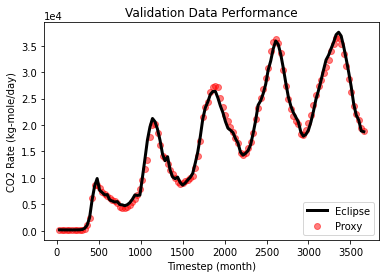

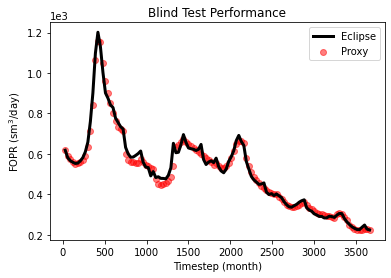

In [26]:
# Defining temporary storage and variables
ts = 1
proxy_result = np.empty(shape=(1,5))
FOPR_before = 0.491075203
CO2_before = 0.003634399

# Taking the blind test condition
halfcycle_blind = blind_database['Halfcycle day'][0]
qg_blind = blind_database['qgtot'][0]
qw_blind = blind_database['qwtot'][0]

# Looping through 122 timesteps
for ts in range (1, 123):
    ts_norm = (ts-1)/(122-1)
    CO2_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, CO2_before]])
    FOPR_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, FOPR_before]])
        
    # Determine whether to use gas or water proxy
    temp = math.floor((ts-1)/(halfcycle_blind*9+3))
    if (temp % 2) == 0:
        if ts <= 12:
            FOPR = fopr_gas_model1.predict(FOPR_input)
            CO2 = co2_model0.predict(CO2_input)
        elif ts <= 30:
            FOPR = fopr_gas_model1.predict(FOPR_input)
            CO2 = co2_gas_model1.predict(CO2_input)
        elif ts <= 60:
            FOPR = fopr_gas_model2.predict(FOPR_input)
            CO2 = co2_gas_model2.predict(CO2_input)
        elif ts <= 90:
            FOPR = fopr_gas_model3.predict(FOPR_input)
            CO2 = co2_gas_model3.predict(CO2_input)
        else:
            FOPR = fopr_gas_model4.predict(FOPR_input)
            CO2 = co2_gas_model4.predict(CO2_input)
    else:
        if ts <= 12:
            FOPR = fopr_wat_model1.predict(FOPR_input)
            CO2 = co2_model0.predict(CO2_input)
        elif ts <= 30:
            FOPR = fopr_wat_model1.predict(FOPR_input)
            CO2 = co2_wat_model1.predict(CO2_input)
        elif ts <= 60:
            FOPR = fopr_wat_model2.predict(FOPR_input)
            CO2 = co2_wat_model2.predict(CO2_input)
        elif ts <= 90:
            FOPR = fopr_wat_model3.predict(FOPR_input)
            CO2 = co2_wat_model3.predict(CO2_input)
        else:
            FOPR = fopr_wat_model4.predict(FOPR_input)
            CO2 = co2_wat_model4.predict(CO2_input)
    
    # transfer value from array to one value
    FOPR = FOPR[0,0]
    CO2 = CO2[0,0]
    
    result = np.array([[ts_norm, CO2_before, CO2, FOPR_before, FOPR]])
    proxy_result = np.append(proxy_result, result, axis = 0)
    
    CO2_before = CO2
    FOPR_before = FOPR
    
# Throwing dummy value in index 0
proxy_result = proxy_result[1:,:]

# Plotting the result
real_timestep = proxy_result[:,0]*(3660-30)+30
real_CO2_eclipse = CO2_blind_label[:]*(62301.45703+0)+0
real_CO2_proxy = proxy_result[:,2]*(62301.45703+0)+0
real_FOPR_eclipse = FOPR_blind_label[:]*(1558.028809-0)+0
real_FOPR_proxy = proxy_result[:,4]*(1558.028809-0)+0

plt.figure(20)
if Case_ID > 86:
    plt.title('Blind Test Performance')
elif Case_ID in val_case:
    plt.title('Validation Data Performance')
else:
    plt.title('Training Data Performance')
plt.xlabel('Timestep (month)')
plt.ylabel('CO2 Rate (kg-mole/day)')
plt.plot(real_timestep[:], real_CO2_eclipse[:], label='Eclipse', color='black', linewidth=3)
plt.scatter(real_timestep[:], real_CO2_proxy[:], label='Proxy', linestyle='-', color='red', alpha=0.5)
plt.legend(['Eclipse', 'Proxy'], loc='lower right')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

plt.figure(21)
if Case_ID > 68:
    plt.title('Blind Test Performance')
elif Case_ID in val_case:
    plt.title('Validation Data Performance')
else:
    plt.title('Training Data Performance')
plt.xlabel('Timestep (month)')
plt.ylabel('FOPR (sm$^3$/day)')
plt.plot(real_timestep[:], real_FOPR_eclipse[:], label='Eclipse', color='black', linewidth=3)
plt.scatter(real_timestep[:], real_FOPR_proxy[:], label='Proxy', linestyle='-', color='red', alpha=0.5)
plt.legend(['Eclipse', 'Proxy'], loc='upper right')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

## Run all data
All data that we have in the database (Training, Validation, Blind Test)

In [30]:
proxy_result = np.empty(shape=(1,3))

for Case_ID in range (1,110):
    blind_database = blind_proxy_database[blind_proxy_database['Case'] == Case_ID].reset_index()

    # Making dataset for FOPR proxy
    FOPR_blind_label = blind_database['FOPR [sm3/d]'].to_numpy()

    # Making dataset for FCO2PR proxy
    CO2_blind_label = blind_database['FCO2PR [kg-mole/d]'].to_numpy()
        
    # Defining temporary storage and variables
    ts = 1
    FOPR_before = 0.491075203
    CO2_before = 0.003634399

    # Taking the blind test condition
    halfcycle_blind = blind_database['Halfcycle day'][0]
    qg_blind = blind_database['qgtot'][0]
    qw_blind = blind_database['qwtot'][0]
    
    # Looping through 122 timesteps
    for ts in range (1, 123):
        ts_norm = (ts-1)/(122-1)
        CO2_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, CO2_before]])
        FOPR_input = np.array([[halfcycle_blind, qg_blind, qw_blind, ts_norm, FOPR_before]])

        # Determine whether to use gas or water proxy
        temp = math.floor((ts-1)/(halfcycle_blind*9+3))
        if (temp % 2) == 0:
            if ts <= 12:
                FOPR = fopr_gas_model1.predict(FOPR_input)
                CO2 = co2_model0.predict(CO2_input)
            elif ts <= 30:
                FOPR = fopr_gas_model1.predict(FOPR_input)
                CO2 = co2_gas_model1.predict(CO2_input)
            elif ts <= 60:
                FOPR = fopr_gas_model2.predict(FOPR_input)
                CO2 = co2_gas_model2.predict(CO2_input)
            elif ts <= 90:
                FOPR = fopr_gas_model3.predict(FOPR_input)
                CO2 = co2_gas_model3.predict(CO2_input)
            else:
                FOPR = fopr_gas_model4.predict(FOPR_input)
                CO2 = co2_gas_model4.predict(CO2_input)
        else:
            if ts <= 12:
                FOPR = fopr_wat_model1.predict(FOPR_input)
                CO2 = co2_model0.predict(CO2_input)
            elif ts <= 30:
                FOPR = fopr_wat_model1.predict(FOPR_input)
                CO2 = co2_wat_model1.predict(CO2_input)
            elif ts <= 60:
                FOPR = fopr_wat_model2.predict(FOPR_input)
                CO2 = co2_wat_model2.predict(CO2_input)
            elif ts <= 90:
                FOPR = fopr_wat_model3.predict(FOPR_input)
                CO2 = co2_wat_model3.predict(CO2_input)
            else:
                FOPR = fopr_wat_model4.predict(FOPR_input)
                CO2 = co2_wat_model4.predict(CO2_input)

        # transfer value from array to one value
        FOPR = FOPR[0,0]
        CO2 = CO2[0,0]
        
        # Denormalization
        ts_real = ts_norm*(3660-30)+30
        real_CO2_proxy = CO2*(62301.45703+0)+0
        real_FOPR_proxy = FOPR*(1558.028809-0)+0
        
        result = np.array([[ts_real, real_CO2_proxy, real_FOPR_proxy]])
        proxy_result = np.append(proxy_result, result, axis = 0)

        CO2_before = CO2
        FOPR_before = FOPR

# Throwing dummy value in index 0
proxy_result = proxy_result[1:,:]

ProxyResult = pd.DataFrame(proxy_result, columns=['Timestep', 'CO2 Proxy', 'FOPR Proxy'])

ProxyResult.to_excel("ProxyAllRun.xlsx",sheet_name='RunResults')

KeyboardInterrupt: 

# Optimization Study
Performing optimization study using the proxy

In [20]:
## Proxy defined as functions
def oilproxy (halfcycle,qg,qw):
    #Normalization
    halfcycle_norm = (halfcycle-3)/(12-3)
    qg_norm = (qg-1)/(2-1)
    qw_norm = (qw-3000)/(9000-3000)

    # Defining temporary storage and variables
    ts = 1
    proxy_result = np.empty(shape=(1,2))
    FOPR_before = 0.491075203

    # Looping through 122 timesteps
    for ts in range (1, 123):
        ts_norm = (ts-1)/(122-1)
        FOPR_input = np.array([[halfcycle_norm, qg_norm, qw_norm, ts_norm, FOPR_before]])

        # Determine whether to use gas or water proxy
        temp = math.floor((ts-1)/(halfcycle_norm*9+3))
        if (temp % 2) == 0:
            if ts <= 12:
                FOPR = fopr_gas_model1.predict(FOPR_input)
            elif ts <= 30:
                FOPR = fopr_gas_model1.predict(FOPR_input)
            elif ts <= 60:
                FOPR = fopr_gas_model2.predict(FOPR_input)
            elif ts <= 90:
                FOPR = fopr_gas_model3.predict(FOPR_input)
            else:
                FOPR = fopr_gas_model4.predict(FOPR_input)
        else:
            if ts <= 12:
                FOPR = fopr_wat_model1.predict(FOPR_input)
            elif ts <= 30:
                FOPR = fopr_wat_model1.predict(FOPR_input)
            elif ts <= 60:
                FOPR = fopr_wat_model2.predict(FOPR_input)
            elif ts <= 90:
                FOPR = fopr_wat_model3.predict(FOPR_input)
            else:
                FOPR = fopr_wat_model4.predict(FOPR_input)

        # transfer value from array to one value
        FOPR = FOPR[0,0]
        result = np.array([[ts_norm, FOPR]])
        proxy_result = np.append(proxy_result, result, axis = 0)
        FOPR_before = FOPR

    # Throwing dummy value in index 0
    proxy_result = proxy_result[1:,:]

    # Plotting the result
    FOPT_time = (proxy_result[:,1]*(1558.028809-0)+0)*30
    FOPT = np.sum(FOPT_time)
    
    return FOPT

def co2proxy1 (halfcycle,qg,qw):
    #Normalization
    halfcycle_norm = (halfcycle-3)/(12-3)
    qg_norm = (qg-1)/(2-1)
    qw_norm = (qw-3000)/(9000-3000)

    # Defining temporary storage and variables
    ts = 1
    proxy_result = np.empty(shape=(1,2))
    CO2_before = 0.003634399

    # Looping through 122 timesteps
    for ts in range (1, 123):
        ts_norm = (ts-1)/(122-1)
        CO2_input = np.array([[halfcycle_norm, qg_norm, qw_norm, ts_norm, CO2_before]])

        # Determine whether to use gas or water proxy
        temp = math.floor((ts-1)/(halfcycle_norm*9+3))
        if (temp % 2) == 0:
            if ts <= 12:
                CO2 = co2_model0.predict(CO2_input)
            elif ts <= 30:
                CO2 = co2_gas_model1.predict(CO2_input)
            elif ts <= 60:
                CO2 = co2_gas_model2.predict(CO2_input)
            elif ts <= 90:
                CO2 = co2_gas_model3.predict(CO2_input)
            else:
                CO2 = co2_gas_model4.predict(CO2_input)
        else:
            if ts <= 12:
                CO2 = co2_model0.predict(CO2_input)
            elif ts <= 30:
                CO2 = co2_wat_model1.predict(CO2_input)
            elif ts <= 60:
                CO2 = co2_wat_model2.predict(CO2_input)
            elif ts <= 90:
                CO2 = co2_wat_model3.predict(CO2_input)
            else:
                CO2 = co2_wat_model4.predict(CO2_input)

        # transfer value from array to one value
        CO2 = CO2[0,0]
        result = np.array([[ts_norm, CO2]])
        proxy_result = np.append(proxy_result, result, axis = 0)
        CO2_before = CO2

    # Throwing dummy value in index 0
    proxy_result = proxy_result[1:,:]

    # Denormalization
    FCO2PT_time = (proxy_result[:,1]*(62301.45703+0)+0)*30
    FCO2PT = np.sum(FCO2PT_time)
    
    return FCO2PT

def CO2proxy(halfcycle,qg,qw):
    time1 = math.floor(122 / (2 * halfcycle))
    time2 = 122%(2 * halfcycle)
    if math.floor(time2 / halfcycle)==0:
        gas_time = time1 * halfcycle + time2
    else:
        gas_time = time1 * halfcycle + halfcycle
    
    ## units in Msm3
    sequestrated_co2 = gas_time * qg * 30 - co2proxy1(halfcycle,qg,qw)/42221
    return sequestrated_co2

In [1]:
122%(2 * 9)

14

#### Performing optimization study using NSGA-II

In [27]:
# Define problem
import time
import numpy as np
start_time = time.time()

from pymoo.model.problem import FunctionalProblem

objs = [
    lambda x : -oilproxy(x[0],x[1],x[2]),
    lambda x : -CO2proxy(x[0],x[1],x[2])    
]

constr_ieq = [
    lambda x : x[0]%3
]

functional_problem = FunctionalProblem(3,
                                       objs,
                                       constr_ieq=constr_ieq,
                                       xl=np.array([3,1,3000]),
                                       xu=np.array([12,2,9000]))

# Defining the integer and real value
mask = ["int", "real", "real"]

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
    "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=3.0),
    "int": get_mutation("int_pm", eta=3.0)
})

# test_problem = MyProblem()
problem = functional_problem

# Optimization Algorithm
from pymoo.algorithms.nsga2 import NSGA2

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True
)

# Define termination criterion
from pymoo.factory import get_termination

termination = get_termination("n_gen", 100)

# Perform Optimization study
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end_time = time.time()
total_time = end_time-start_time

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      40 |  0.00000E+00 |  0.775000000 |       4 |            - |            -
    2 |      50 |  0.00000E+00 |  0.575000000 |       4 |  0.00000E+00 |            f
    3 |      60 |  0.00000E+00 |  0.375000000 |       7 |  0.103741255 |            f
    4 |      70 |  0.00000E+00 |  0.250000000 |       7 |  0.00000E+00 |            f
    5 |      80 |  0.00000E+00 |  0.175000000 |       8 |  0.011863487 |            f
    6 |      90 |  0.00000E+00 |  0.050000000 |       8 |  0.00000E+00 |            f
    7 |     100 |  0.00000E+00 |  0.00000E+00 |       9 |  0.014721141 |        ideal
    8 |     110 |  0.00000E+00 |  0.00000E+00 |       9 |  0.00000E+00 |            f
    9 |     120 |  0.00000E+00 |  0.00000E+00 |       7 |  0.098828154 |        ideal
   10 |     130 |  0.00000E+00 |  0.00000E+00 |       6 |  0.061686722 |        ideal
   11 |     140 |  0.00000E+00 |  0.00000E+00 |       

   94 |     970 |  0.00000E+00 |  0.00000E+00 |      30 |  0.001507099 |            f
   95 |     980 |  0.00000E+00 |  0.00000E+00 |      30 |  0.00000E+00 |            f
   96 |     990 |  0.00000E+00 |  0.00000E+00 |      30 |  0.00000E+00 |            f
   97 |    1000 |  0.00000E+00 |  0.00000E+00 |      31 |  0.000624380 |            f
   98 |    1010 |  0.00000E+00 |  0.00000E+00 |      32 |  0.000118815 |            f
   99 |    1020 |  0.00000E+00 |  0.00000E+00 |      32 |  0.00000E+00 |            f
  100 |    1030 |  0.00000E+00 |  0.00000E+00 |      32 |  0.000144258 |            f


### Assessing the pareto optimum results

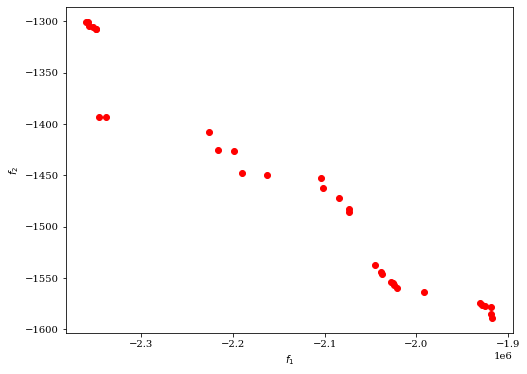

In [29]:
from pymoo.visualization.scatter import Scatter
plot = Scatter()
plot.add(res.F, color="red")
plot.show()

In [30]:
res.X

array([[6, 1.9936597786866121, 3824.8482248774253],
       [9, 1.950332476029982, 6453.818741047197],
       [6, 1.9936597786866121, 3980.64632107857],
       [6, 1.994485573907254, 4428.354928446686],
       [9, 1.989223707966187, 7616.036315424465],
       [9, 1.995660829671841, 3202.345139515285],
       [9, 1.9939028897429376, 3106.641700678267],
       [6, 1.9994958074175062, 3489.145018291998],
       [6, 1.98753090269023, 8918.335058112782],
       [9, 1.9847503965525517, 3164.789411923234],
       [6, 1.9829117986200144, 8902.882377703685],
       [6, 1.9988205933897203, 4932.807038456842],
       [6, 1.98246873606607, 8902.882377703685],
       [6, 1.98753090269023, 8998.925552368692],
       [6, 1.9979324950573174, 3801.697840584365],
       [6, 1.9937570232601487, 3964.6772814086567],
       [6, 1.988791498953224, 5034.868185208238],
       [9, 1.9979324950573174, 3245.418994191581],
       [9, 1.9648407376188652, 7136.063024921358],
       [6, 1.9946141514062137, 3849.55430

In [31]:
res.F

array([[-2.02523240e+06, -1.55452236e+03],
       [-2.16304969e+06, -1.44970657e+03],
       [-2.03877800e+06, -1.54431224e+03],
       [-2.07335286e+06, -1.48333005e+03],
       [-2.22625638e+06, -1.40739018e+03],
       [-1.92557335e+06, -1.57734140e+03],
       [-1.91833274e+06, -1.58511094e+03],
       [-1.99183081e+06, -1.56396627e+03],
       [-2.35262265e+06, -1.30518436e+03],
       [-1.91873061e+06, -1.57798789e+03],
       [-2.34999534e+06, -1.30736413e+03],
       [-2.10165389e+06, -1.46263192e+03],
       [-2.34982169e+06, -1.30760517e+03],
       [-2.35667142e+06, -1.30428279e+03],
       [-2.02419811e+06, -1.55724029e+03],
       [-2.03743138e+06, -1.54570198e+03],
       [-2.10358916e+06, -1.45300258e+03],
       [-1.93054897e+06, -1.57410900e+03],
       [-2.19910983e+06, -1.42681500e+03],
       [-2.02773086e+06, -1.55399411e+03],
       [-2.04530107e+06, -1.53762857e+03],
       [-2.07310007e+06, -1.48585651e+03],
       [-2.34661340e+06, -1.39296713e+03],
       [-2.